In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
def plot_synthetic_data2(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)


    ax[3].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [4]:
def plot_synthetic_data(ax, obs, gamma, xs, zs, lams, trial, trial_color):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    # i = 3
        
    ax[0].plot(x, lams[:,0,l], color=trial_color)
    ax[0].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[0].margins(0)
    ax[0].set_ylabel('Intensity', size = label_size)

    ax[2].plot(x, lams[:,1,l], color=trial_color)
    ax[2].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[2].margins(0)
    ax[2].set_ylabel('Intensity', size = label_size)

    ax[4].plot(x, lams[:,2,l], color=trial_color)
    ax[4].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[4].margins(0)
    ax[4].set_ylabel('Intensity', size = label_size)

    ax[1].plot(x, obs[:,0,l], color=trial_color)
    ax[1].set_title(r'$\lambda_t^{1, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[1].margins(0)
    ax[1].set_ylabel('Intensity', size = label_size)

    ax[3].plot(x, obs[:,1,l], color=trial_color)
    ax[3].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[3].margins(0)
    ax[3].set_ylabel('Intensity', size = label_size)

    ax[5].plot(x, obs[:,2,l], color=trial_color)
    ax[5].set_title(r'$\lambda_t^{2, c,\ell}$   $c = 1$  $\ell = (1,2,3)$', size=title_size)
    ax[5].margins(0)
    ax[5].set_ylabel('Intensity', size = label_size)


    ax[5].set_xlabel('Time (sec)', size = label_size)
    # plt.xlim([0,sample_length/fs])


In [5]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

In [6]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [7]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

for alpha in 100 250 500

do

    for scale_init in 1000 100000 10000000 

In [8]:
num_iters = 20

#1000000 10000000 100000000
scale_init = 10000000

lcfg_attrs = {'L': 25}

mcfg_attrs = {'emiters': num_iters,
              'scale_init': scale_init}

ocfg_attrs = {'obs_type': 'pp_relu'}

# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-10',
#              '/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-11']
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-12']
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/batch/outputs/k3-sweep-alpha-init']
# for res_path in res_paths:
#     clean_dir(res_path)

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in res_load])
alphas = sorted([r['cfg'].obs.alpha for r in res_load])


3 paths found meeting critera


In [9]:
scale_inits = [1000000, 10000000, 100000000]
# scale_inits = [1000, 100000, 10000000]
alphas = [100, 250, 500]

In [10]:
alpha = 250
osel = {'alpha': alpha}
res = filter_loaded(res_load, {}, {}, osel)
cfg = res['cfg']
gamma_true = res['gamma_true_full']

Returned single result.


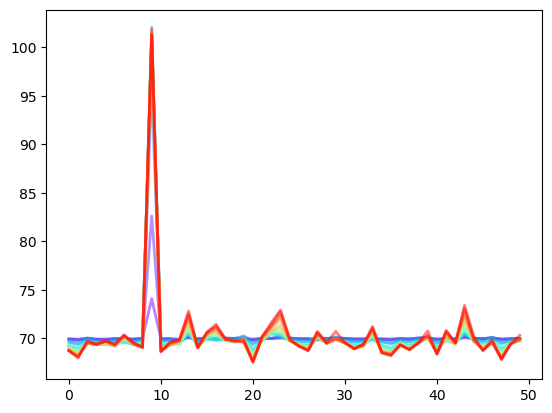

In [11]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots()
plot_spec_em_iters(ax, res['track']['gamma'], k, dB=dB)

1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera


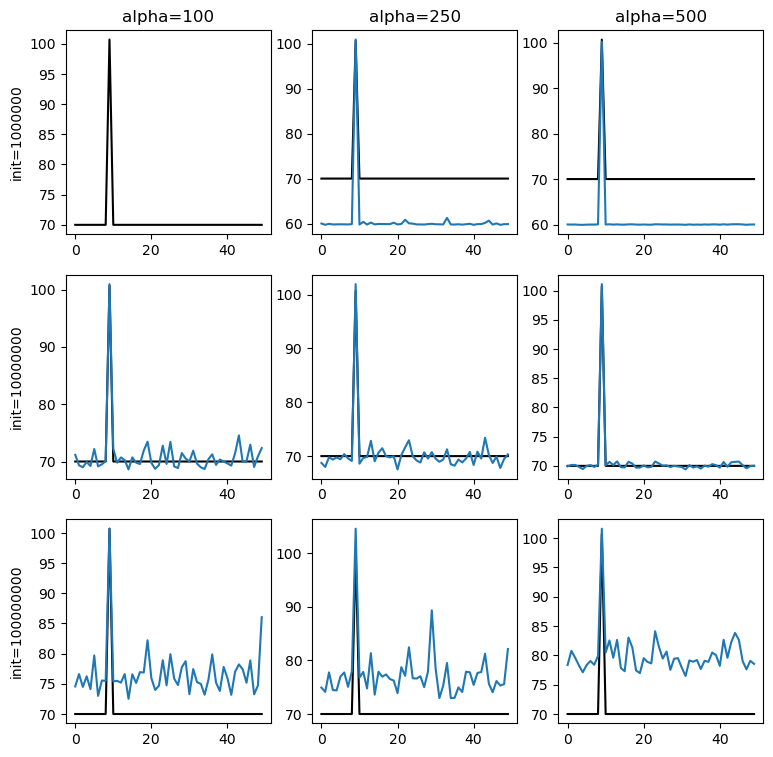

In [12]:
k = 0
dB = True
scale_init = scale_inits[0]
alpha = alphas[0]

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(3,3,figsize=(9,9))
for i, scale_init in enumerate(scale_inits):
    for a, alpha in enumerate(alphas):
        lcfg_attrs = {'L': 25}

        mcfg_attrs = {'emiters': num_iters,
                    'scale_init': scale_init}

        ocfg_attrs = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
        assert len(res_load) == 1
        res = res_load[0]

        gamma_true = res['gamma_true_full']
        gamma_est = res['gamma']
        nz = res['params']['nonzero_inds']
        ax[i,a].plot(transform(gamma_true[nz,k,k].real), color='k')
        ax[i,a].plot(transform(gamma_est[nz,k,k].real), color='tab:blue')
        if i == 0:
            ax[i,a].set_title(f'alpha={alpha}')
        if a == 0:
            ax[i,a].set_ylabel(f'init={scale_init}')

### Next up
- add naive ests
- add cross-spec ests
- add eigval / eigvec ests
- think about others to run

In [13]:
# colors = ['tab:blue', 'tab:orange', 'tab:green']
# freqs = jnp.arange(50)
# fig,ax = plt.subplots(6,1,figsize=(10,8), sharex=True)
# for i in range(3):
#     fig,ax = plt.subplots(6,1,figsize=(10,8), sharex=True)
#     plot_synthetic_data(ax, obs, gamma_true, xs, zs, lams, trial=i, trial_color=colors[i])
#     plt.tight_layout()

In [14]:
lcfg_attrs = {'L': 25}

mcfg_attrs = {'emiters': num_iters,
        'scale_init': scale_init}


In [15]:
from cohlib.jax.dists import naive_estimator

alphas = [100, 250, 500]

naive_ests = {}
for alpha in alphas:
    print(alpha)
    ocfg_attrs = {'obs_type': 'pp_relu',
            'alpha': alpha}
    res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
    res = res_load[0]
    
    cfg = res['cfg']
    lcfg = cfg.latent
    ocfg = cfg.obs
    gamma_true = res['gamma_true_full']
    K = gamma_true.shape[-1]

    lrk = jr.key(lcfg.seed)
    zs = sample_from_gamma(lrk, gamma_true, lcfg.L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)
    params = jnp.array([ocfg.alpha for _ in range(K)])
    print(params)
    lams = cif_alpha_relu(params, xs)


    obs, obs_params = sample_obs(xs, params)
    naive_est = naive_estimator(obs, nz)
    naive_ests[alpha] = naive_est * 1e6

100
1 paths found meeting critera
[100 100 100]
250
1 paths found meeting critera
[250 250 250]
500
1 paths found meeting critera
[500 500 500]


In [16]:
jnp.all(naive_ests[100] == naive_ests[250])

Array(False, dtype=bool)

1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera


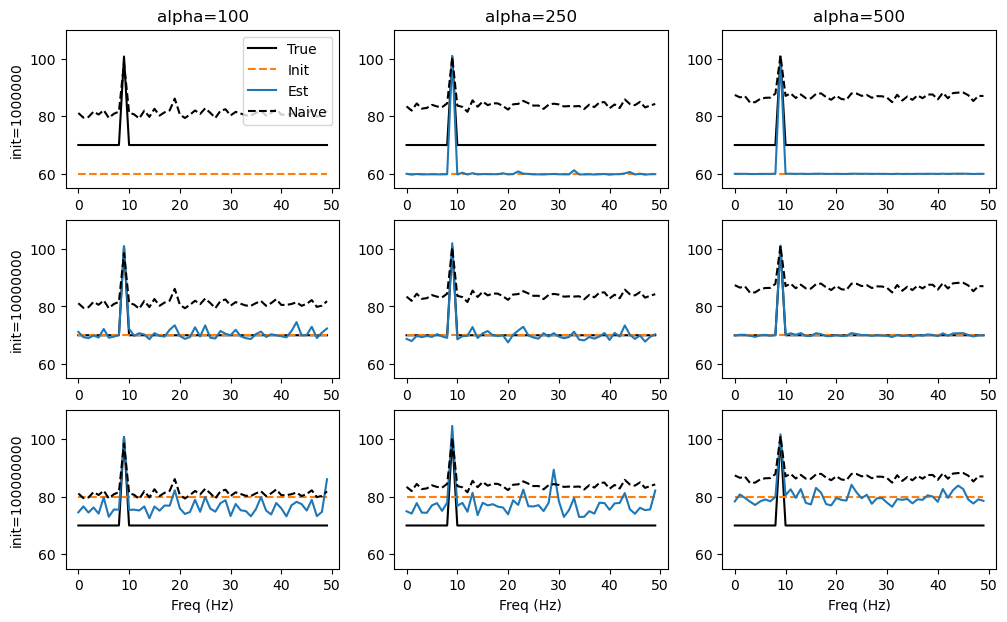

In [23]:
k = 0
dB = True
scale_init = scale_inits[0]
alpha = alphas[0]

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(3,3,figsize=(12,7))
for i, scale_init in enumerate(scale_inits):
    for a, alpha in enumerate(alphas):
        lcfg_attrs = {'L': 25}

        mcfg_attrs = {'emiters': num_iters,
                    'scale_init': scale_init}

        ocfg_attrs = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
        assert len(res_load) == 1
        res = res_load[0]

        gamma_true = res['gamma_true_full']
        gamma_init = res['gamma_init']
        gamma_est = res['gamma']
        nz = res['params']['nonzero_inds']
        ax[i,a].plot(transform(gamma_true[nz,k,k].real), color='k', label='True')
        ax[i,a].plot(transform(gamma_init[nz,k,k].real), color='tab:orange', linestyle='--', label='Init')
        ax[i,a].plot(transform(gamma_est[nz,k,k].real), color='tab:blue', label='Est')
        ax[i,a].plot(transform(naive_ests[alpha][nz,k,k].real), color='k', linestyle='--', label='Naive')
        if i == 0 and a == 0:
            ax[i,a].legend()
        if i == 0:
            ax[i,a].set_title(f'alpha={alpha}')
        if a == 0:
            ax[i,a].set_ylabel(f'init={scale_init}')
        if i == 2:
            ax[i,a].set_xlabel('Freq (Hz)')
        
        if dB is True:
            ax[i,a].set_ylim([55, 110])
        else:
            ax[i,a].set_ylim([1e6, 1e11])


1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera
1 paths found meeting critera


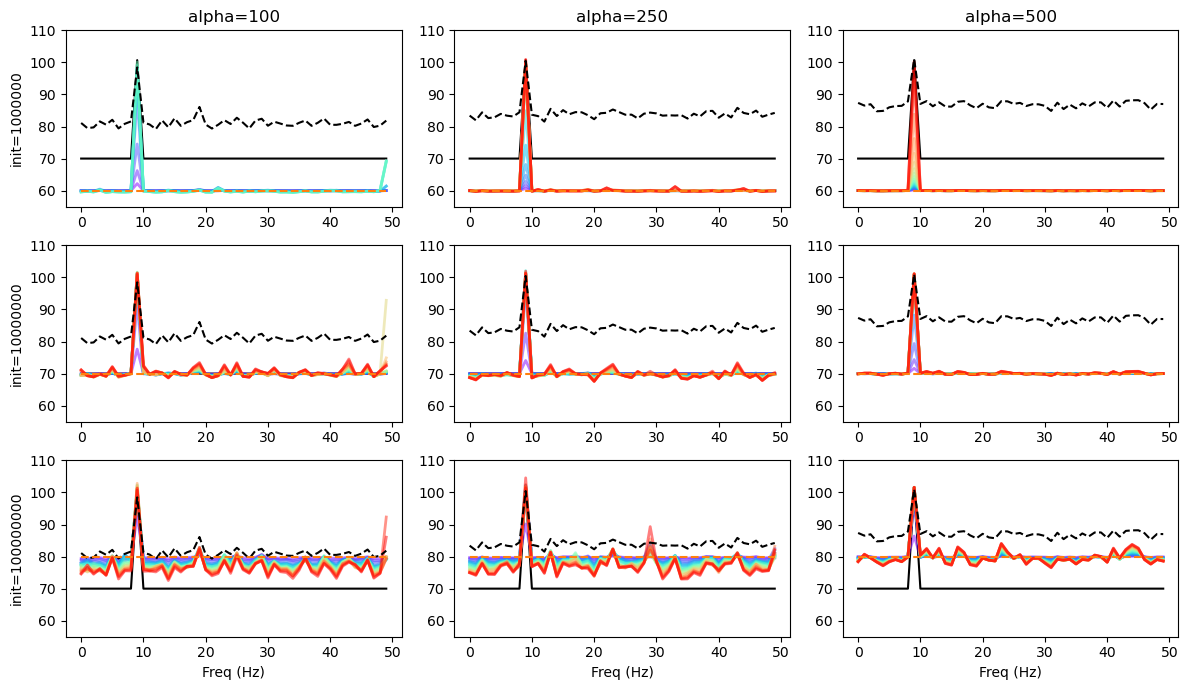

In [25]:
k = 0
dB = True
scale_init = scale_inits[0]
alpha = alphas[0]

if dB is True:
    transform = db_transform
else:
    transform = identity

fig, ax = plt.subplots(3,3,figsize=(12,7))
for i, scale_init in enumerate(scale_inits):
    for a, alpha in enumerate(alphas):
        lcfg_attrs = {'L': 25}

        mcfg_attrs = {'emiters': num_iters,
                    'scale_init': scale_init}

        ocfg_attrs = {'obs_type': 'pp_relu',
                    'alpha': alpha}
        res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
        assert len(res_load) == 1
        res = res_load[0]

        gamma_true = res['gamma_true_full']
        gamma_init = res['gamma_init']
        nz = res['params']['nonzero_inds']
        ax[i,a].plot(transform(gamma_true[nz,k,k].real), color='k')
        plot_spec_em_iters(ax[i,a], res['track']['gamma'], k, dB=dB)
        ax[i,a].plot(transform(naive_ests[alpha][nz,k,k].real), color='k', linestyle='--')
        ax[i,a].plot(transform(gamma_init[nz,k,k].real), color='tab:orange', linestyle='--')
        if i == 0:
            ax[i,a].set_title(f'alpha={alpha}')
        if a == 0:
            ax[i,a].set_ylabel(f'init={scale_init}')
        if i == 2:
            ax[i,a].set_xlabel('Freq (Hz)')
        if dB is True:
            ax[i,a].set_ylim([55, 110])
        else:
            ax[i,a].set_ylim([1e6, 1e11])
plt.tight_layout()


In [56]:
alpha = 250
scale_init = 10000000

lcfg_attrs = {'L': 25}

mcfg_attrs = {'emiters': num_iters,
            'scale_init': scale_init}

ocfg_attrs = {'obs_type': 'pp_relu',
            'alpha': alpha}
res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
res = res_load[0]

1 paths found meeting critera


In [67]:
print(jnp.round(res['gamma'][9,:,:], -7))

[[ 1.565e+10+1.00e+07j -3.160e+09-6.05e+09j -1.220e+09-5.02e+09j]
 [-3.160e+09+6.05e+09j  1.102e+10+0.00e+00j  4.320e+09+3.60e+08j]
 [-1.220e+09+5.02e+09j  4.320e+09-3.60e+08j  5.780e+09-0.00e+00j]]


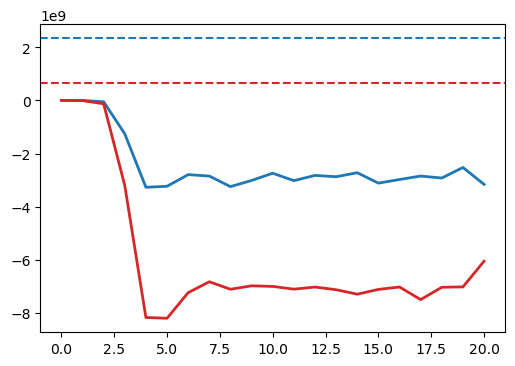

In [58]:
def plot_cross_spec_em_iters(ax, i, j, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,i,j].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,i,j].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

jind = 9 
i = 1
j = 2
fig, ax = plt.subplots(figsize=(6,4))
plot_cross_spec_em_iters(ax, i,j, res['track']['gamma'], res['gamma_init'], j_ind = jind)
ax.axhline(res['gamma_true_full'][jind,i,j].real, linestyle='--', color='tab:blue')
ax.axhline(res['gamma_true_full'][jind,i,j].imag, linestyle='--', color='tab:red')

In [68]:
jnp.linalg.eigh(res['gamma_true_full'][9,:,:])[0]

Array([2.9999987e+09, 5.9999995e+09, 1.5000001e+10], dtype=float32)

In [71]:
print(jnp.linalg.eigh(res['gamma'][9,:,:])[0].sort()[::-1])

def get_eigval(mat, rank):
    eigvals_sorted = jnp.linalg.eigh(mat)[0].sort()[::-1]
    return eigvals_sorted[rank]

get_eigval(res['gamma'][9,:,:], 1)

[2.3133995e+10 6.2707645e+09 3.0389737e+09]


Array(6.2707645e+09, dtype=float32)

In [72]:
def plot_cross_spec_eigval_em_iters(ax, eigrank, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    # cs_real = jnp.array([gamma_init[j_ind,i,j].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    # cs_imag = jnp.array([gamma_init[j_ind,i,j].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    eigs = jnp.array([get_eigval(gamma_init[j_ind,:,:], eigrank)] + [get_eigval(gamma_r[j_ind,:,:], eigrank) for gamma_r in gamma_iter_list])
    # init_val = jnp.linalg.eigh(gamma_init[j_ind,:,:])[0].sort()[::-1]

    ax.plot(eigs, color='tab:blue', linewidth=2)
    # ax.plot(cs_imag, color='tab:red', linewidth=2)

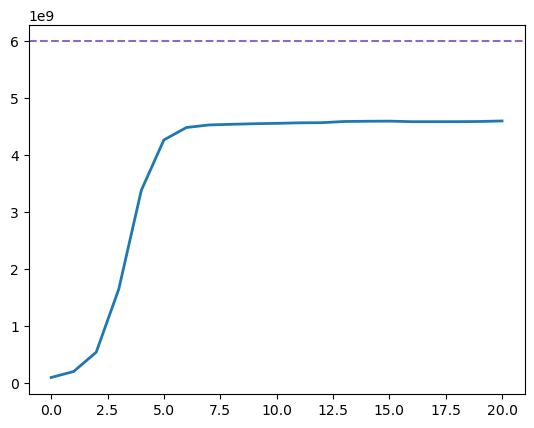

In [81]:
j_ind = 9
eigrank = 1
true_eigvals = jnp.linalg.eigh(res['gamma_true_full'][9,:,:])[0].sort()[::-1]


fig, ax = plt.subplots()
plot_cross_spec_eigval_em_iters(ax, eigrank, res['track']['gamma'], res['gamma_init'], j_ind=j_ind)
ax.axhline(true_eigvals[eigrank], linestyle='--', color='tab:purple')

In [ ]:
true_eigvals = jnp.linalg.eigh(res['gamma'][9,:,:])[0].sort()[::-1]

In [37]:
res['gamma'][9,:,:]
res['gamma'][9,:,:]

Array([[ 1.3027154e+10+1.7207658e+07j, -2.7486044e+09-6.7839355e+09j,
        -8.9825440e+08-4.8616136e+09j],
       [-2.7485041e+09+6.7839877e+09j,  1.0540084e+10-6.7879740e+06j,
         4.3416781e+09+5.8582035e+08j],
       [-8.9858458e+08+4.8615951e+09j,  4.3416786e+09-5.8613190e+08j,
         6.0719375e+09-6.3056020e+06j]], dtype=complex64)

In [21]:
res.keys()

dict_keys(['cfg', 'gamma', 'params', 'gamma_init', 'gamma_true_full', 'track'])

In [ ]:
from cohlib.mvcn import thr_coherence



for alpha in alphas:
    res_jax = res_load_conj_mod[alpha]

    osel = {'alpha': alpha}
    res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    j_ind = 9
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    gamma_naive = naive_ests[alpha]

    fig, ax = plt.subplots(1,2, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{alpha}')
    ax[0].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[0].axhline(gamma_naive[j_ind,0,1].real, linestyle='--', color='tab:purple')
    ax[1].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[0].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[0].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:orange')
    ax[0].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:purple')
    ax[1].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[1].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:orange')
    plot_cross_spec_em_iters(ax[0], res_jax['track']['gamma'], gamma_init, j_ind)
    ax[0].set_title('Jax - original')
    plot_cross_spec_em_iters(ax[1], res_jax_refac['track'], gamma_init, j_ind)
    ax[1].set_title('Jax - new mod')
    ax[0].set_xlabel('EM Iter')
    ax[1].set_xlabel('EM Iter')
    ylabel = r"$\Gamma_{1,2}$"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)

    # ax[0].set_ylim([-0.1,1])
    # ax[1].set_ylim([-0.1,1])
    # ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

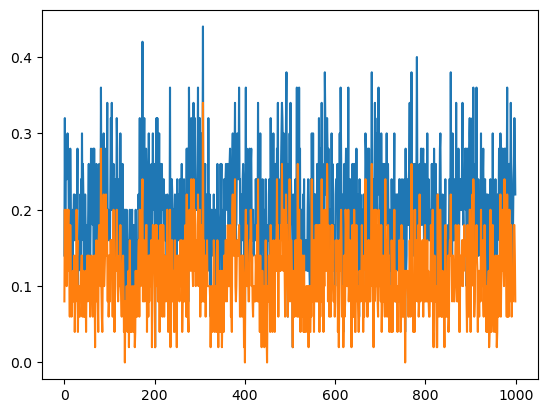

In [48]:
k = 1
plt.plot(obs[:,k,:].mean(-1))
plt.plot(obs_saved[:,k,:].mean(-1))

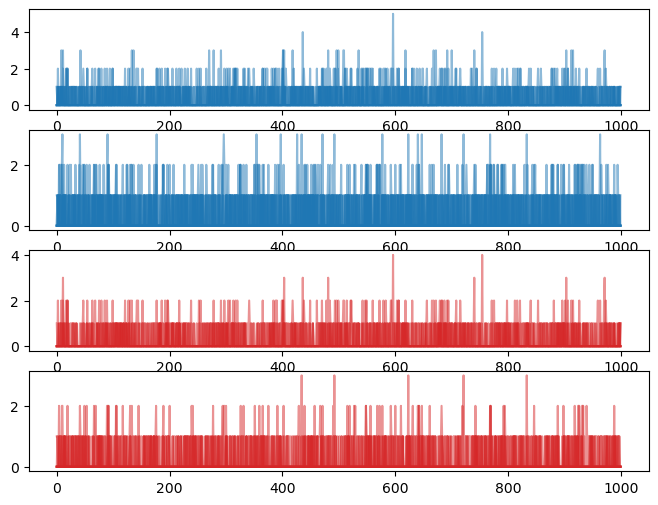

In [43]:
obs_saved.shape

fig, ax = plt.subplots(4,1,figsize=(8,6))
for l in range(10):
    ax[0].plot(obs[:,0,l], color='tab:blue', alpha=0.5)
    ax[1].plot(obs[:,1,l], color='tab:blue', alpha=0.5)
    ax[2].plot(obs_saved[:,0,l], color='tab:red', alpha=0.5)
    ax[3].plot(obs_saved[:,1,l], color='tab:red', alpha=0.5)

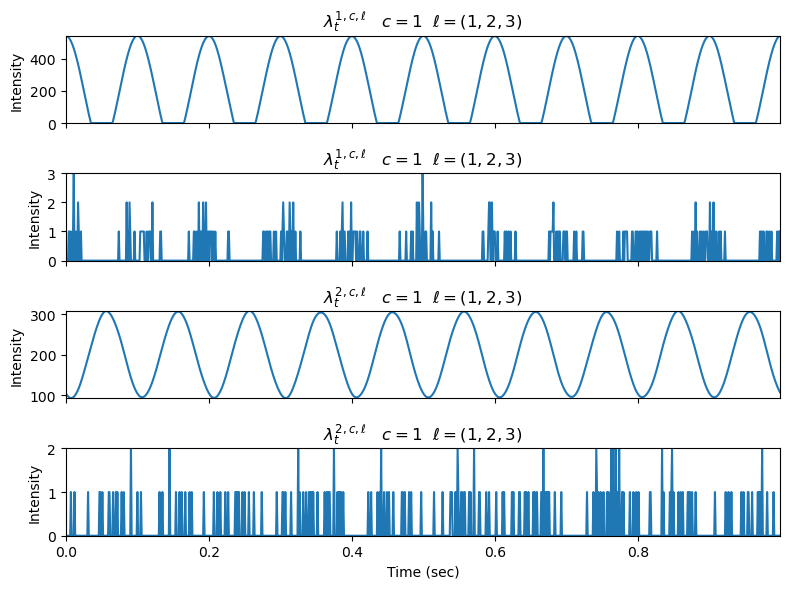

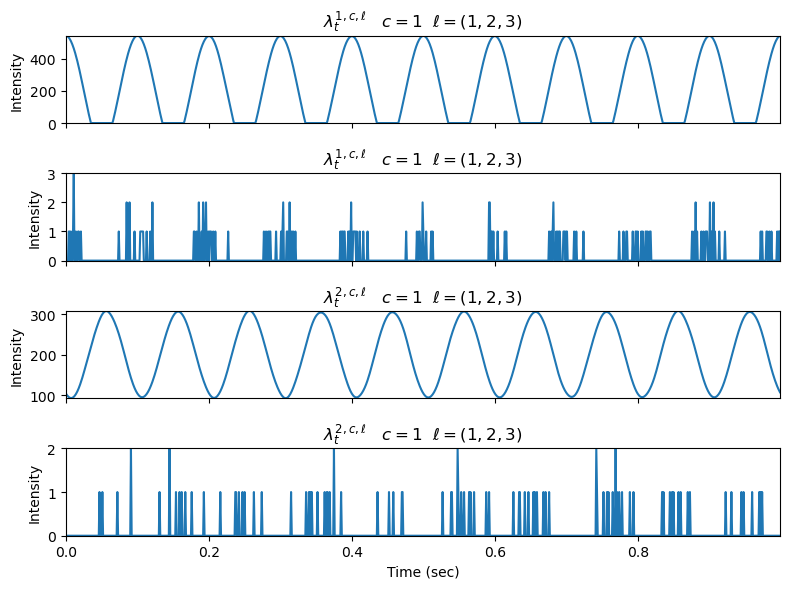

In [40]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
# freqs = jnp.arange(50)
# fig,ax = plt.subplots(6,1,figsize=(10,8), sharex=True)
for i in range(1):
    fig,ax = plt.subplots(4,1,figsize=(8,6), sharex=True)
    plot_synthetic_data2(ax, obs, gamma_true, xs, zs, lams, trial=i, trial_color=colors[i])
    plt.tight_layout()
for i in range(1):
    fig,ax = plt.subplots(4,1,figsize=(8,6), sharex=True)
    plot_synthetic_data2(ax, obs_saved, gamma_true, xs, zs, lams, trial=i, trial_color=colors[i])
    plt.tight_layout()

In [17]:
# from cohlib.jax.models import ToyModel
# gamma_init = jnp.zeros_like(gamma)
# gamma_init_nz = jnp.stack([scale_gamma*jnp.eye(K) for j in range(J)])
# gamma_init = gamma_init.at[nz,:,:].set(gamma_init_nz)
# freqs = jnp.arange(500)

# em_iters = 20
# newton_iters = 10

# model = ToyModel()
# model.initialize_latent(gamma_init, freqs, nz)
# model.initialize_observations(obs_params, obs_type)
# model.fit_em(obs, em_iters, newton_iters)

In [26]:
gamma[:,:2,:2].shape

(500, 2, 2)

In [ ]:
def get_globalcoh(Gamma):
    J = Gamma.shape[0]
    gcoh = jnp.zeros(J)

    for j in range(J):
        evals, _ = jnp.linalg.eigh(Gamma[j,:,:])
        gcoh = gcoh.at[j].set(evals.max() / evals.sum())
    
    return gcoh
